## Accessing GBIF data with the Planetary Computer STAC API

This notebook provides an example of accessing [Forest Inventory and Analysis](https://planetarycomputer.microsoft.com/dataset/fia) (FIA) data from the Planetary Computer STAC API.

The Forest Inventory and Analysis collection contains many tables. In this example, we'll use a few of the tables to estimate the total amount of aboveground carbon, in pounds, per US county.

This example builds on the [plot estimation](https://rfia.netlify.app/courses/plt_est/) example from the [rfia](https://rfia.netlify.app/) package.

In [1]:
from cartopy import crs as ccrs
from dask_gateway import GatewayCluster
import dask_geopandas
import dask.dataframe as dd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer

The `tree` table below is relatively large, so we'll process it in parallel on a Dask cluster. The example will still run without a cluster, it will just take longer.

In [2]:
cluster = GatewayCluster()
cluster.scale(16)
client = cluster.get_client()
cluster

### Data Access

We'll use three datsaets

* `tree`: Information on each tree 1″ in diameter or larger, linked to `plot` and `cond`.
* `plot`: Information relevant to each 1-acre field plot where the samples were collected.
* `cond`: Information on the discrete combination of landscape attributes that define the plot condition.

All of these are available in Azure Blob Storage as parquet datasets that can be read, for example, by `dask.dataframe`.

In [3]:
storage_options = {"account_name": "cpdataeuwest"}
plot = dd.read_parquet(
    "az:///cpdata/raw/fia/plot.parquet",
    columns=["CN", "STATECD", "COUNTYCD"],
    storage_options=storage_options,
)
cond = dd.read_parquet(
    "az:///cpdata/raw/fia/cond.parquet",
    columns=["PLT_CN", "CONDID"],
    storage_options=storage_options,
)
tree = dd.read_parquet(
    "az:///cpdata/raw/fia/tree.parquet",
    columns=["PLT_CN", "CONDID", "TREE", "DRYBIO_AG", "CARBON_AG", "TPA_UNADJ"],
    storage_options=storage_options,
)

### Join the datasets

The three datasets can be joined on their various keys. Since `tree` is relatively large, we'll join the other (smaller, in-memory) dataframes to it.

In [4]:
df = (
    tree.merge(cond.compute(), on=["PLT_CN", "CONDID"])
    .merge(plot.assign(PLT_CN=plot.CN).compute(), on="PLT_CN")
    .assign(
        bio=lambda df: df.DRYBIO_AG * df.TPA_UNADJ / 2000,
        carbon=lambda df: df.CARBON_AG * df.TPA_UNADJ / 2000,
    )
)
df

,PLT_CN,CONDID,TREE,DRYBIO_AG,CARBON_AG,TPA_UNADJ,CN,STATECD,COUNTYCD,bio,carbon
npartitions=160,,,,,,,,,,,
,int64,int64,int64,float64,float64,float64,int64,int64,int64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


### Compute per-county summaries

The `df` dataframe now includes the state and county FIPS codes, and the (adjusted) aboveground carbon and biomass. We'll group by the geographic boundaries and sum the aboveground carbon and biomass.

In [5]:
result = (
    df.groupby(["STATECD", "COUNTYCD"])[["bio", "carbon"]]
    .sum()
    .compute()
    .reset_index()
    .assign(
        STATE=lambda df: df["STATECD"].astype("string").str.pad(2, fillchar="0"),
        COUNTY=lambda df: df["COUNTYCD"].astype("string").str.pad(3, fillchar="0"),
    )
    .drop(columns=["STATECD", "COUNTYCD"])
)
result.head()

,bio,carbon,STATE,COUNTY
0,10074.437852,5037.218955,01,001
1,29157.164325,14556.032420,01,003
2,17263.761590,8622.437468,01,005
3,18029.465265,9014.732676,01,007
4,9570.726019,4778.990695,01,009


### Plot the results

Now we'll make a chloropleth for the results. We just need to join in the actual geographic boundaries of the datasets, which we can get with geopandas.

Finally, we'll slice the data down to the continental United States (the dataset covers Hawaii, Alaska, and several other territories).

In [6]:
# TODO: replace with STAC, sign
sas_token = planetary_computer.sas.get_token("ai4edataeuwest", "us-census").token

In [8]:
counties = (
    dask_geopandas.read_parquet(
        "abfs://us-census/2020/cb_2020_us_county_500k.parq",
        storage_options={"account_name": "ai4edataeuwest", "credential": sas_token},
        columns=["STATEFP", "COUNTYFP", "geometry"],
    ).rename(columns={"STATEFP": "STATE", "COUNTYFP": "COUNTY"})
).compute()

In [9]:
gdf = geopandas.GeoDataFrame(pd.merge(result, counties, on=["STATE", "COUNTY"]))
df_conus = gdf.cx[-124.784:-66.951, 24.744:49.346]
df_conus.head()

,bio,carbon,STATE,COUNTY,geometry
0,10074.437852,5037.218955,01,001,"POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
1,29157.164325,14556.032420,01,003,"POLYGON ((-88.02858 30.22676, -88.02399 30.230..."
2,17263.761590,8622.437468,01,005,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
3,18029.465265,9014.732676,01,007,"POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
4,9570.726019,4778.990695,01,009,"POLYGON ((-86.96336 33.85822, -86.95967 33.857..."


Finally, we'll plot the (log) of the estimated carbon stored above ground by the trees.

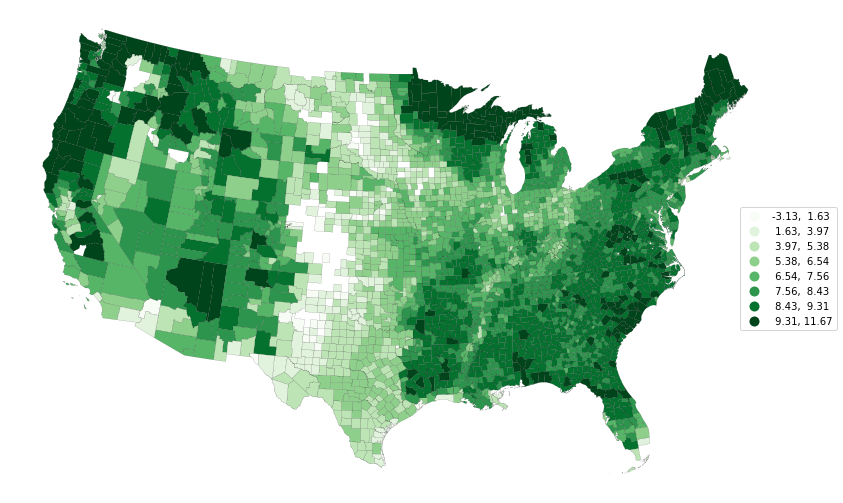

In [42]:
crs = ccrs.LambertConformal()
fig, ax = plt.subplots(subplot_kw={"projection": crs}, figsize=(16, 9))
df_conus.assign(carbon=np.log(df_conus.carbon)).to_crs(crs.proj4_init).plot(
    column="carbon",
    cmap="Greens",
    edgecolor="k",
    scheme="natural_breaks",
    k=8,
    ax=ax,
    linewidths=0.1,
    legend=True,
)

# Shift the legend
bbox = ax.legend_.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
bbox.x0 += 0.075
bbox.x1 += 0.075
bbox.y0 -= 0.4
bbox.y1 -= 0.4
ax.legend_.set_bbox_to_anchor(bbox)

ax.axis("off");